In [7]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

# Data Manipulation

In [8]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-18', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [9]:
amzn = get_finance_data('AMZN')

In [10]:
amzn = amzn.asfreq('D')

In [11]:
amzn.isna().sum()

Open      1439
High      1439
Low       1439
Close     1439
Volume    1439
dtype: int64

In [12]:
amzn = amzn.fillna(method='ffill')

In [13]:
amzn.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [14]:
amzn.index

DatetimeIndex(['2009-02-02', '2009-02-03', '2009-02-04', '2009-02-05',
               '2009-02-06', '2009-02-07', '2009-02-08', '2009-02-09',
               '2009-02-10', '2009-02-11',
               ...
               '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09',
               '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15'],
              dtype='datetime64[ns]', name='Date', length=4639, freq='D')

In [15]:
amzn_close = amzn[['Close']]

In [16]:
amzn_close.head()

,Close
Date,
2009-02-02,61.150002
2009-02-03,63.590000
2009-02-04,61.060001
2009-02-05,63.180000
2009-02-06,66.550003


## ARIMA building

In [17]:
from numpy import log
result = adfuller(amzn_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.762904
p-value: 0.998273


C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


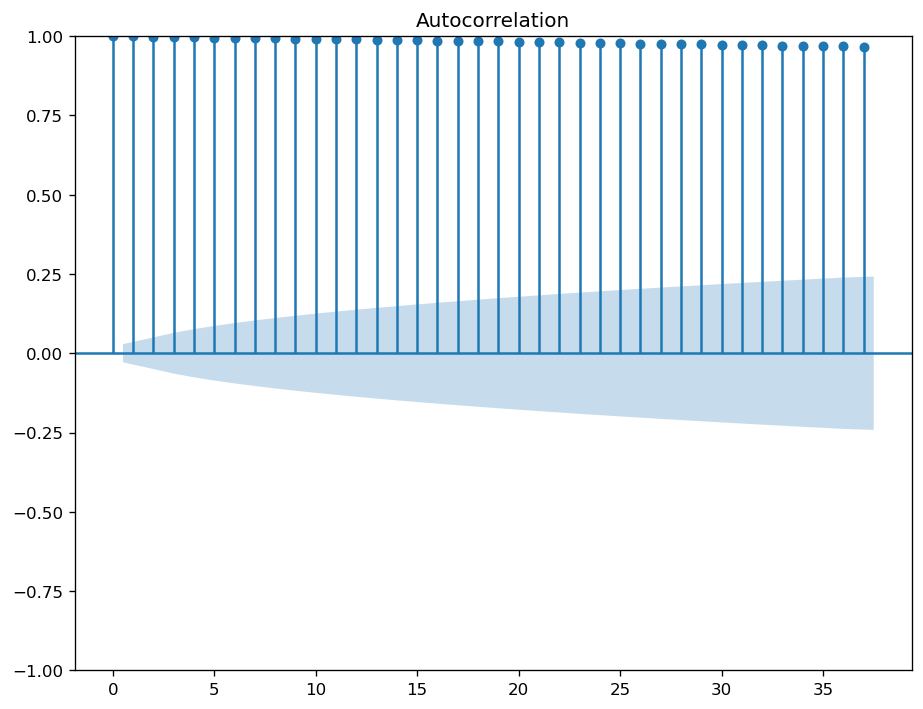

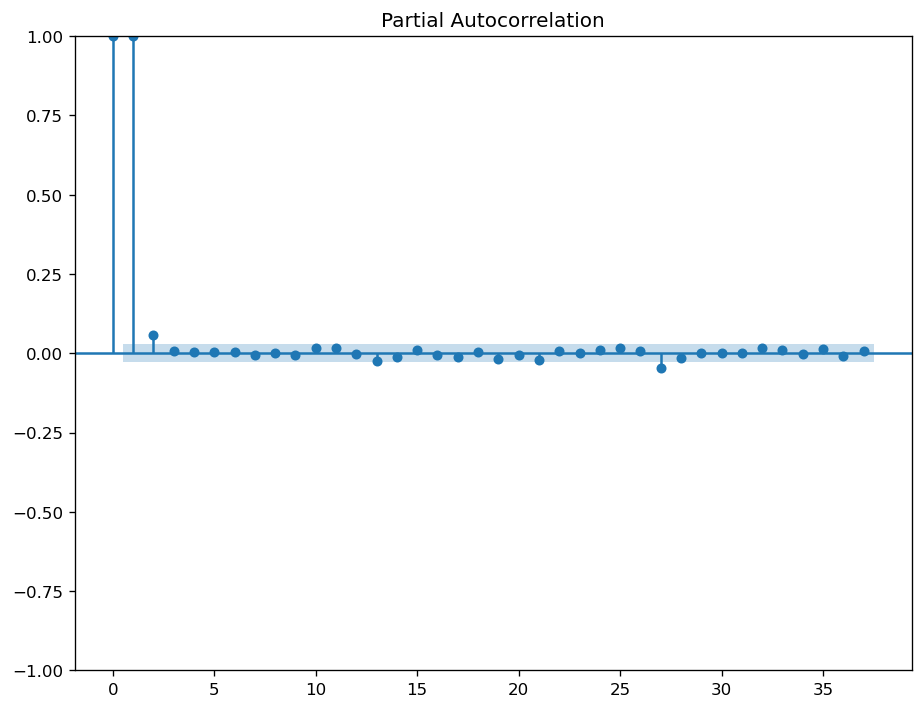

In [18]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
plot_acf(amzn_close)

plot_pacf(amzn_close)

plt.show()

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


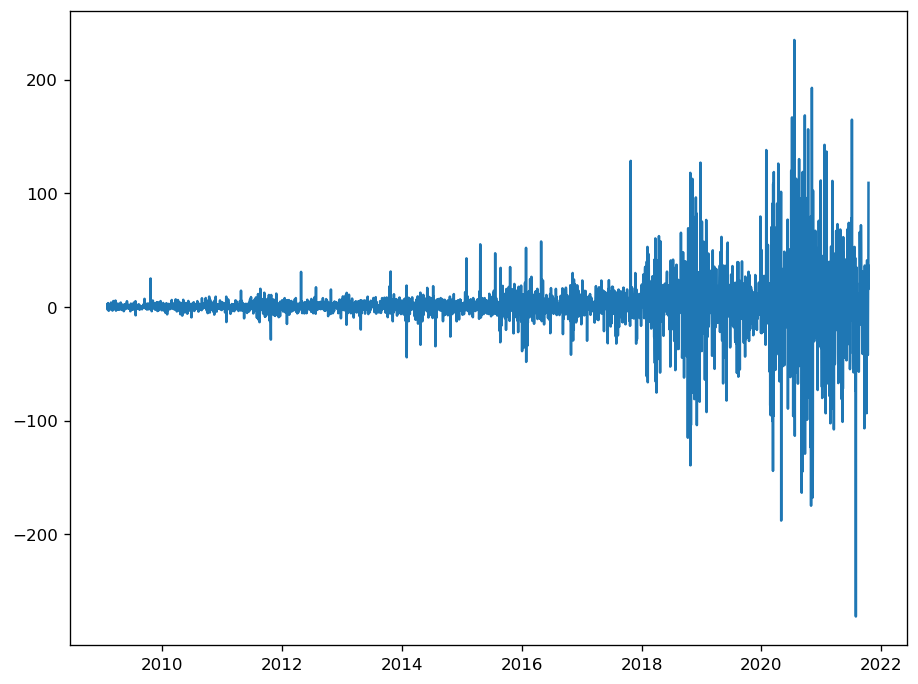

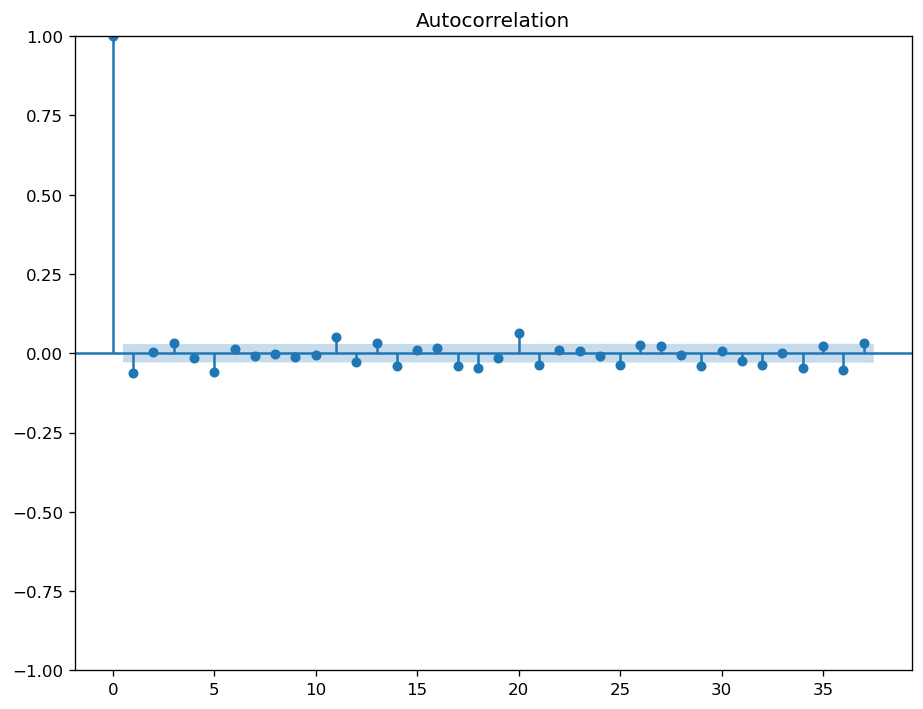

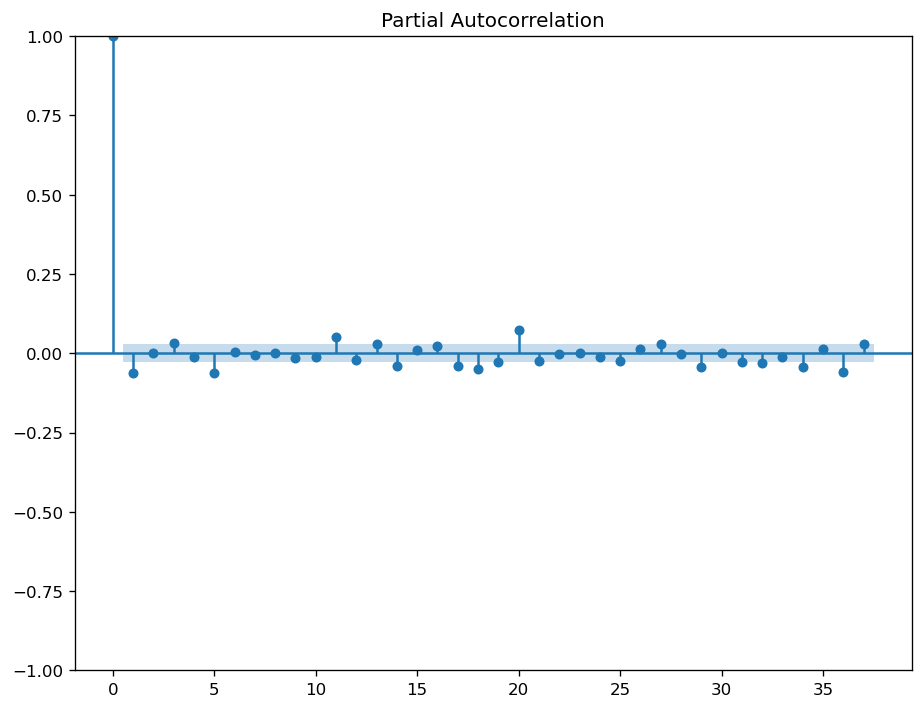

In [19]:
plt.plot(amzn_close.diff().dropna());

plot_acf(amzn_close.diff().dropna());

plot_pacf(amzn_close.diff().dropna());

In [20]:
model = ARIMA(amzn_close, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4639
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -20802.830
Date:                Fri, 22 Oct 2021   AIC                          41609.660
Time:                        07:22:03   BIC                          41622.544
Sample:                    02-02-2009   HQIC                         41614.193
                         - 10-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0603      0.006     -9.851      0.000      -0.072      -0.048
sigma2       460.6885      2.554    180.363      0.000     455.682     465.695
Ljung-Box (L1) (Q):                   0.01   Jarque-

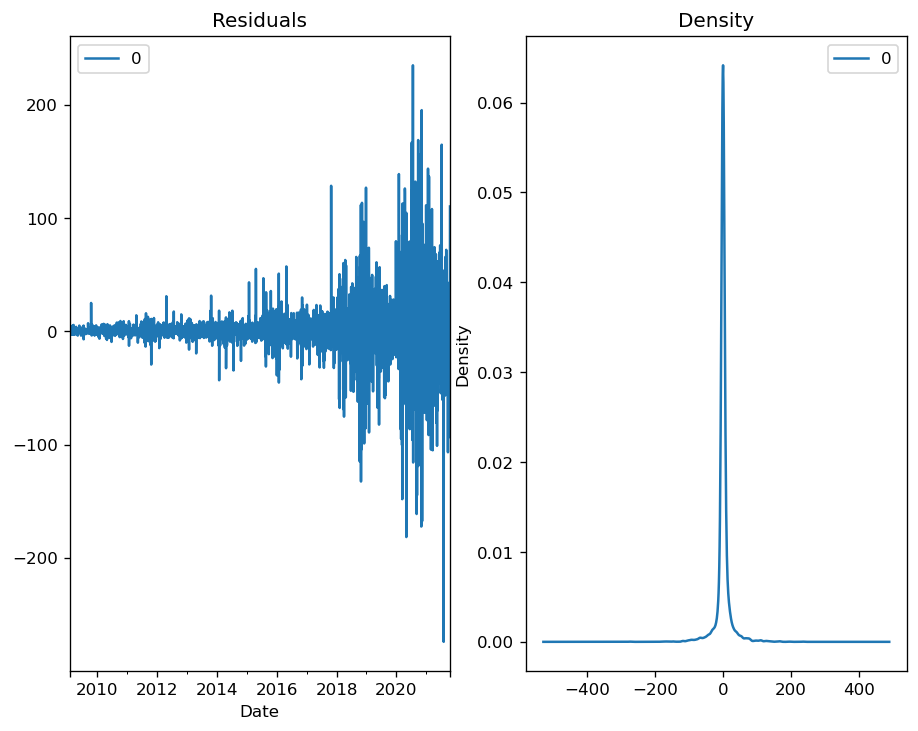

In [21]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [24]:
n = int(len(amzn_close) * 0.85)
train = amzn_close[:n]
test = amzn_close[n:]

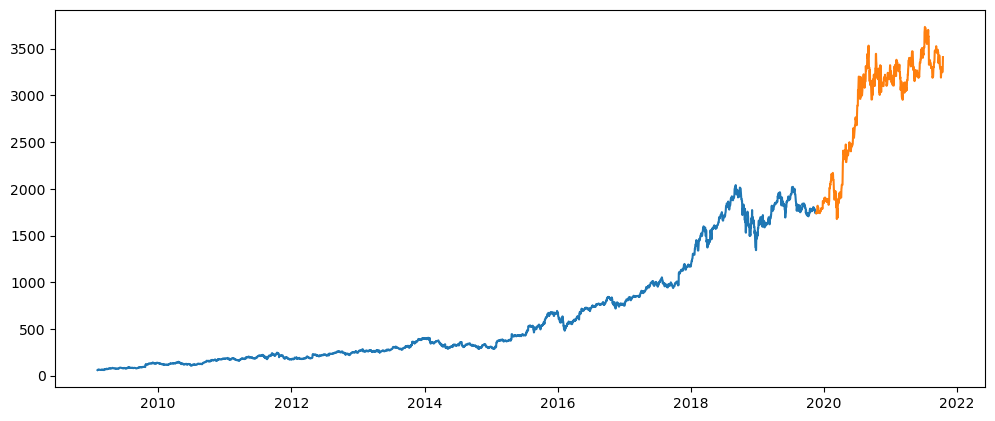

In [25]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [26]:
pred = model_fit.predict(start=pd.to_datetime('2018-09-07'), dynamic=False)
plt.show()

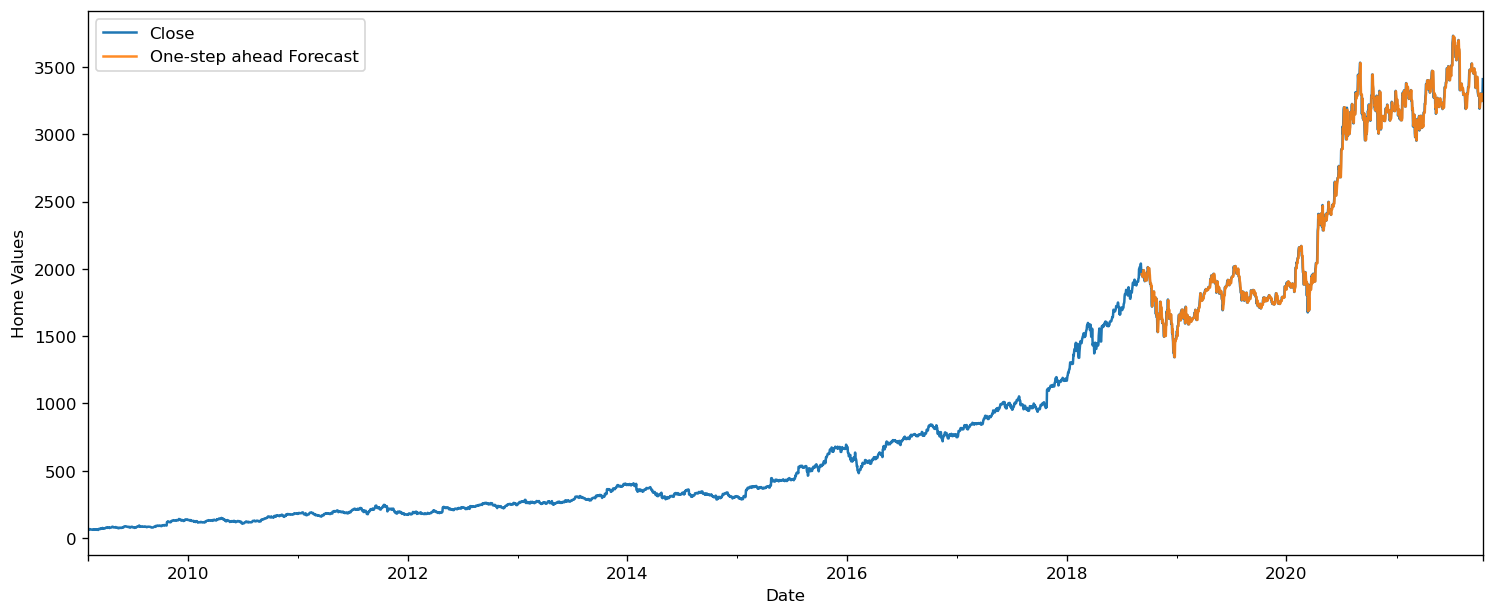

In [27]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = amzn_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();


In [28]:
value_forecasted = pred
value_truth = amzn_close['Close']['2018-09-07':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 40.75


## Trying to forecast

In [29]:
prediction = model_fit.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

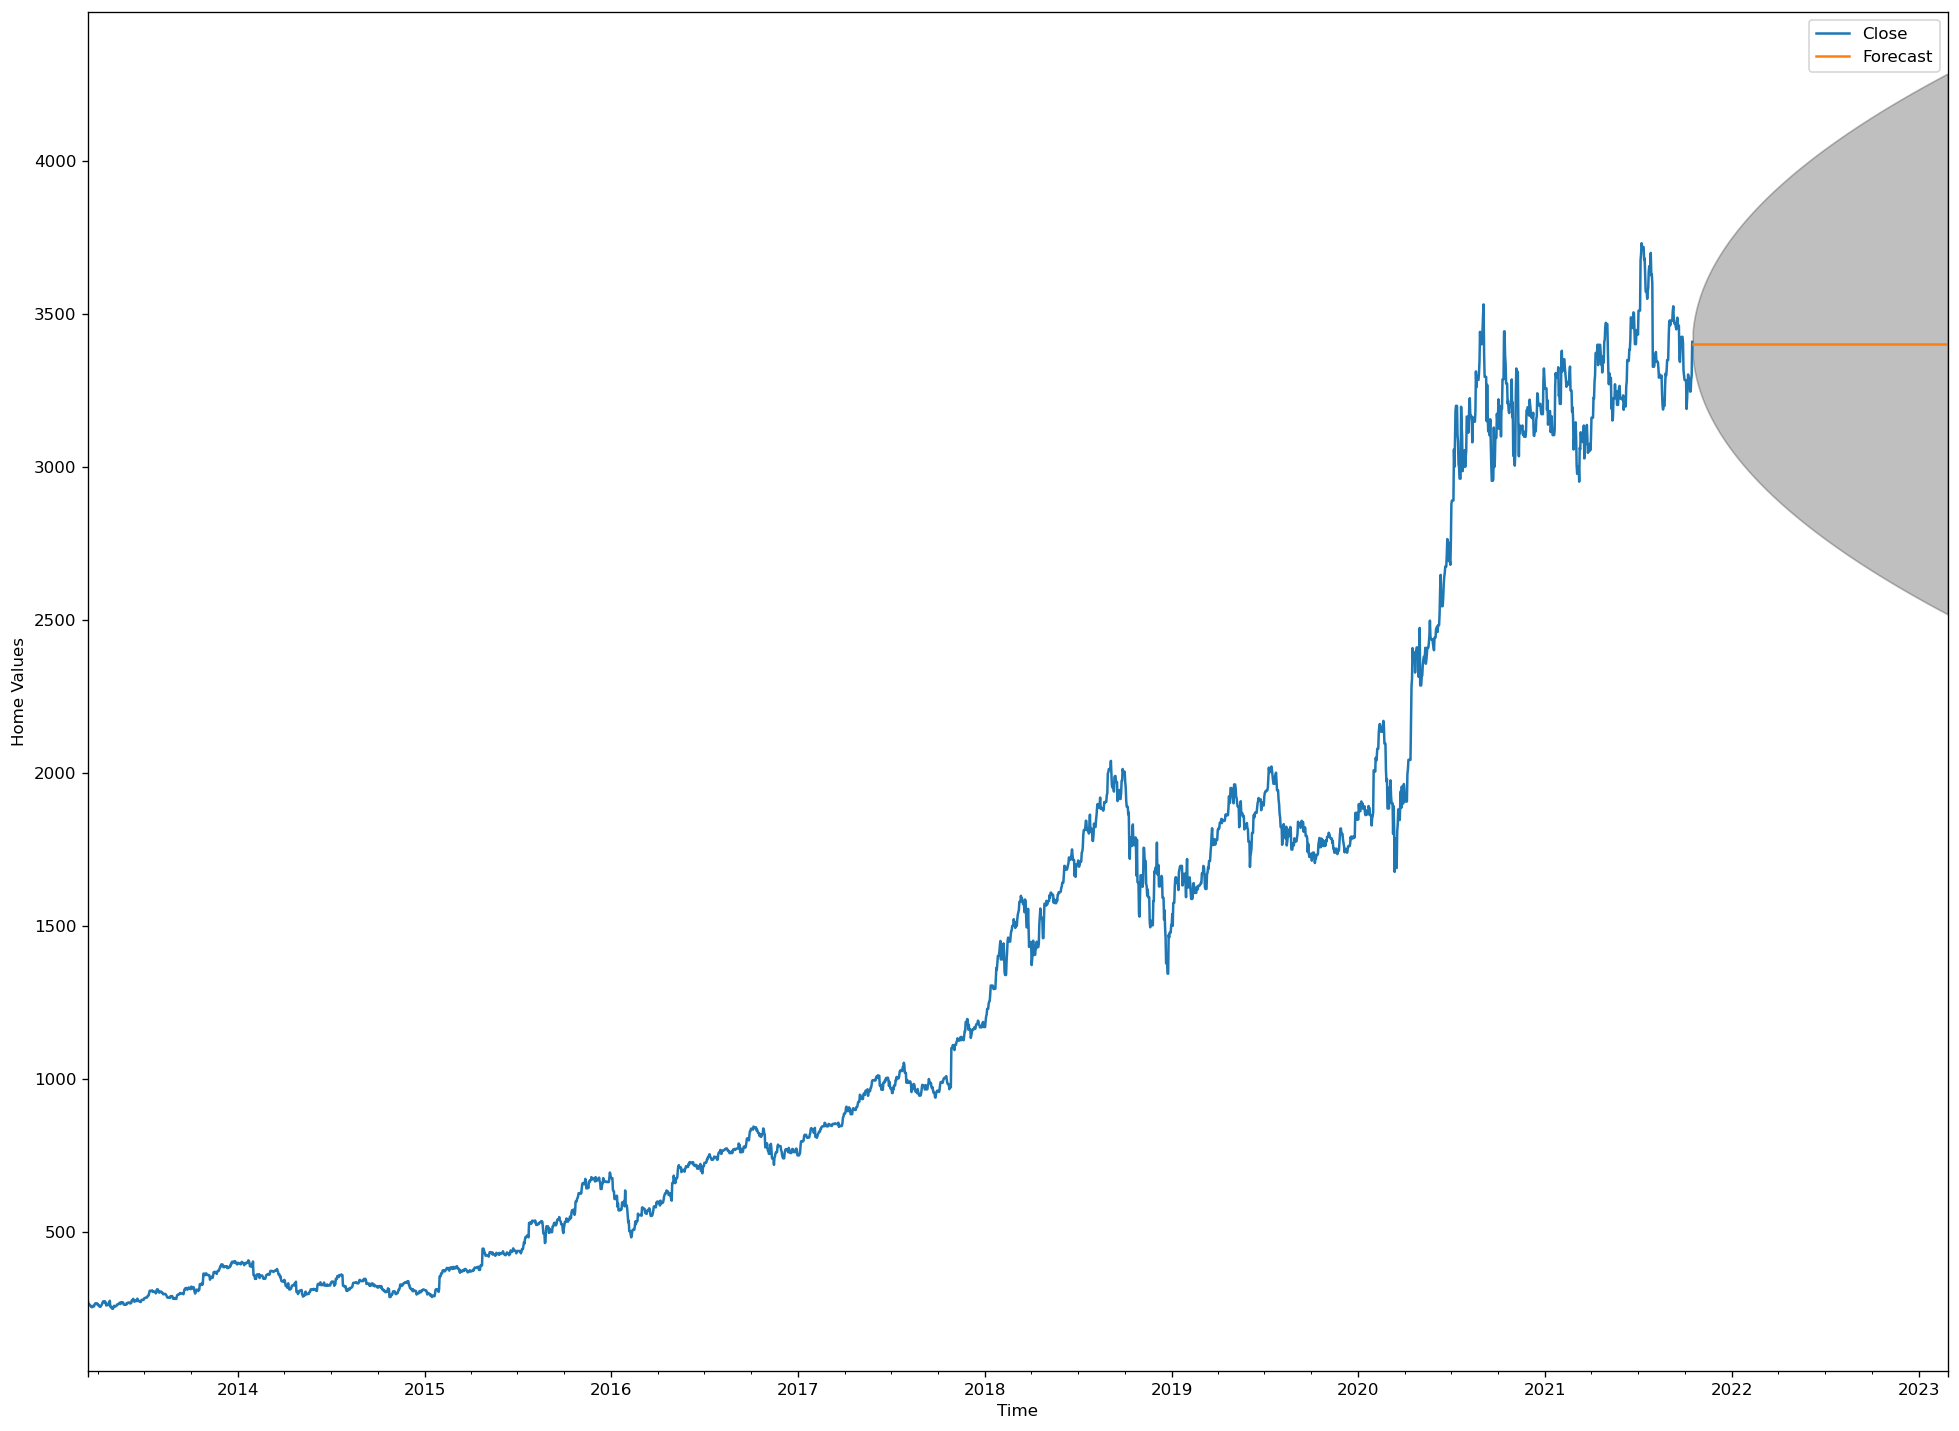

In [30]:
ax = amzn_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show()

In [31]:
prediction.predicted_mean

2021-10-16    3402.369979
2021-10-17    3402.369979
2021-10-18    3402.369979
2021-10-19    3402.369979
2021-10-20    3402.369979
                 ...     
2023-02-23    3402.369979
2023-02-24    3402.369979
2023-02-25    3402.369979
2023-02-26    3402.369979
2023-02-27    3402.369979
Freq: D, Name: predicted_mean, Length: 500, dtype: float64

## PMD

In [32]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [33]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [34]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31105.879, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31135.807, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31113.847, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31112.884, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31138.413, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31105.224, Time=1.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31114.346, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31114.675, Time=0.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=31101.068, Time=2.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=31101.574, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=31102.712, Time=1.00 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=31102.518, Time=3.40 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=31101.876, Time=1.24 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=31104.718, Time=2.81 sec
 ARIMA(1,1,3)(0,0,0

In [35]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3943
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -15544.534
Date:                Fri, 22 Oct 2021   AIC                          31101.068
Time:                        07:23:17   BIC                          31138.744
Sample:                             0   HQIC                         31114.433
                               - 3943                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6130      0.277      2.209      0.027       0.069       1.157
ar.L1         -0.4282      0.085     -5.041      0.000      -0.595      -0.262
ma.L1          0.3508      0.084      4.171      0.0

In [36]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 2196.5995050252054
SMAPE: 1.038579631237968


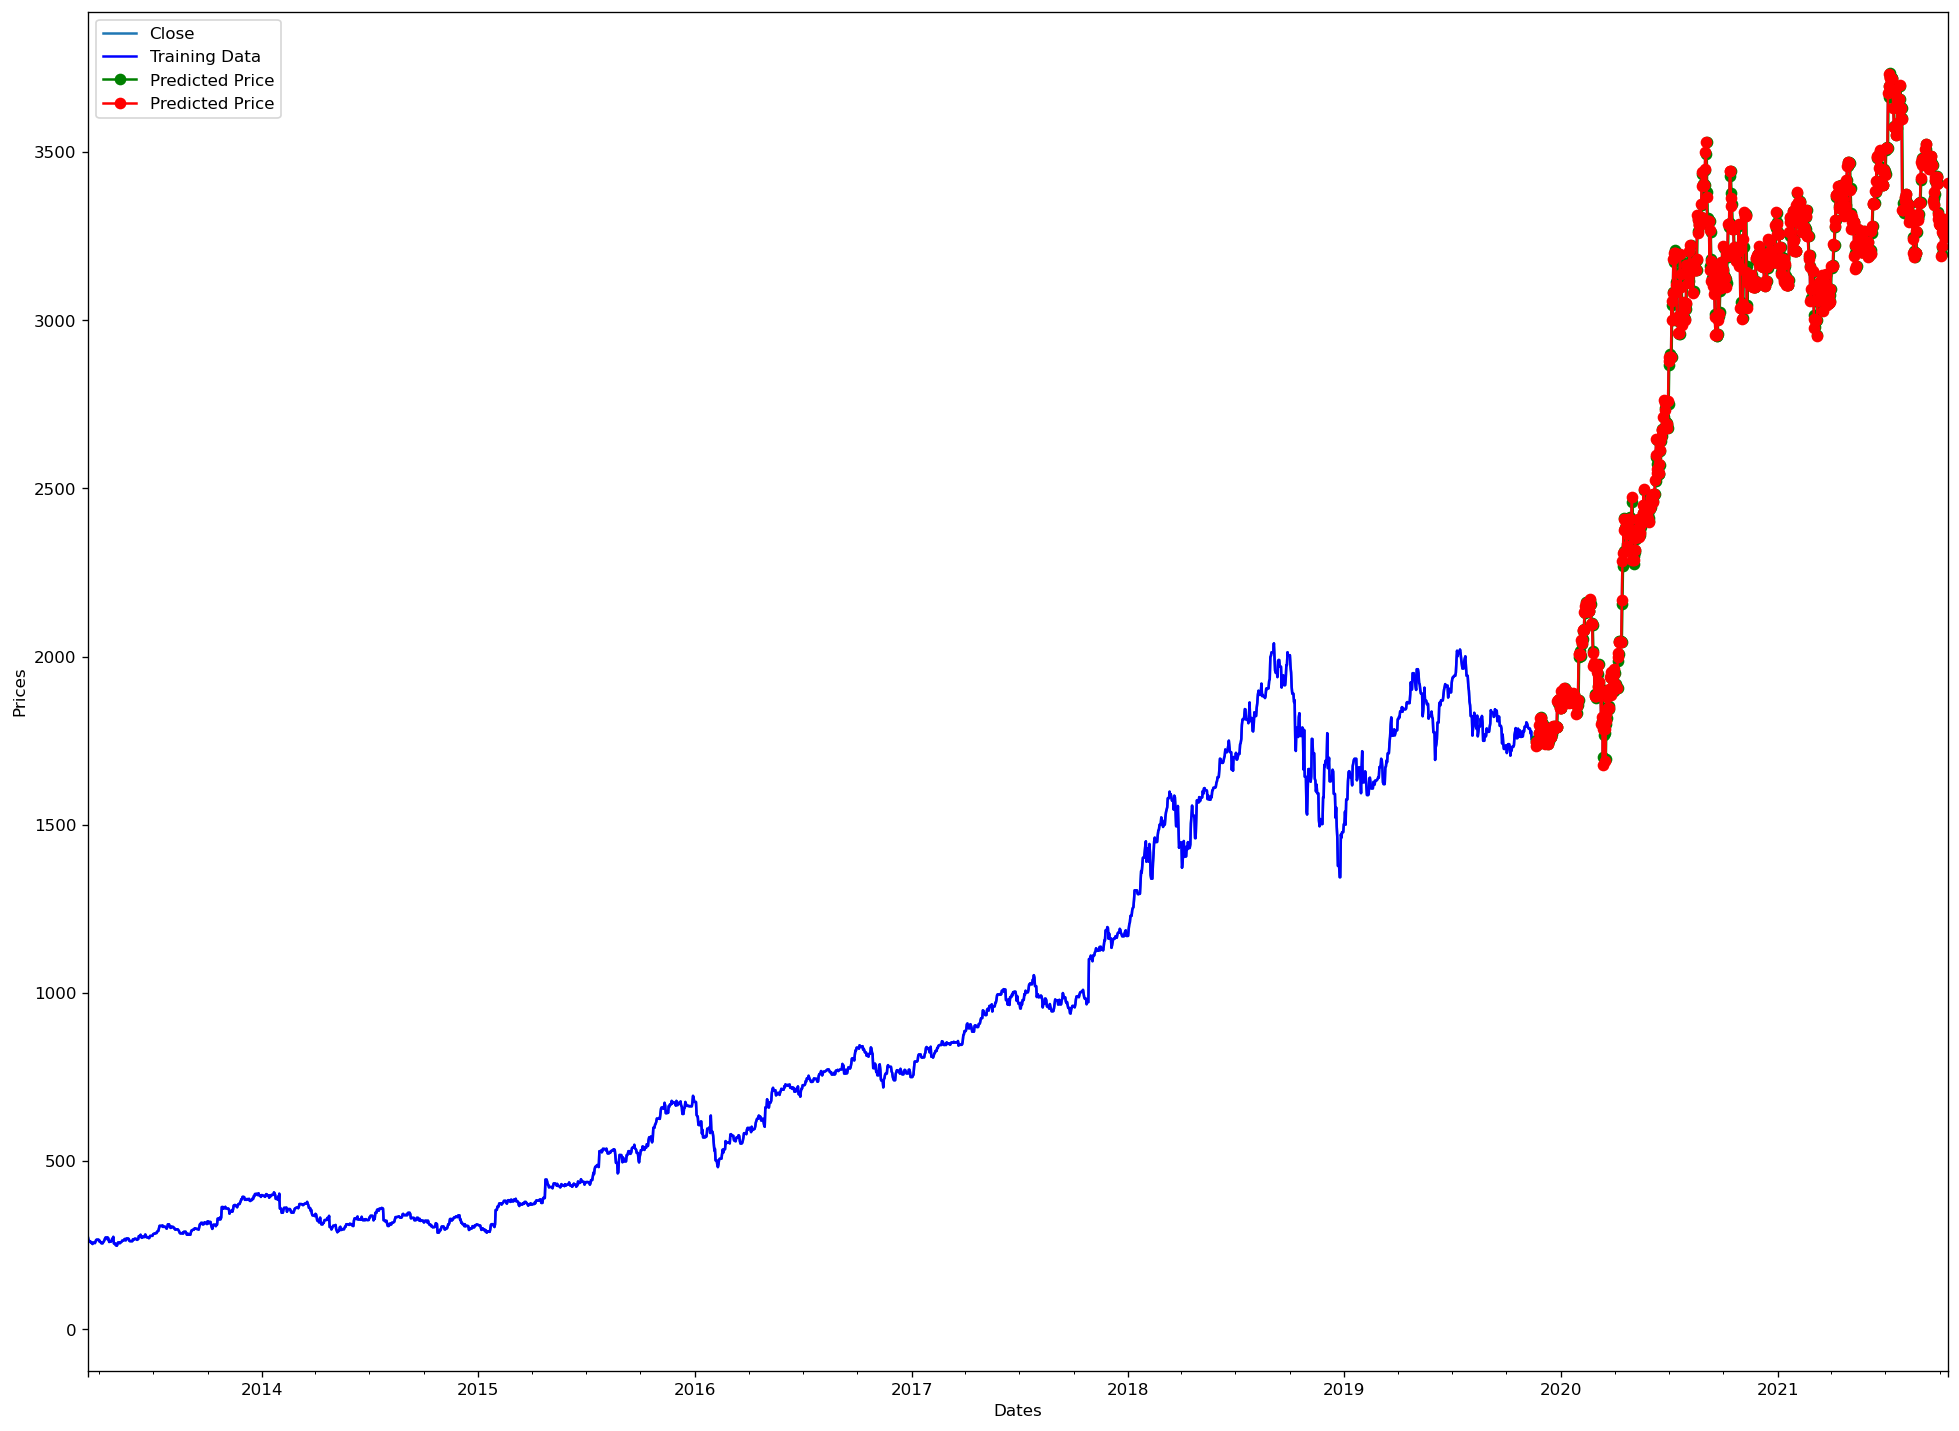

In [38]:
ax = amzn_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [40]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(2196.5995050252054), 2)))

The Root Mean Squared Error of prediction is 46.87


In [41]:
pred_uc = model_fit.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

<AxesSubplot:xlabel='Date'>

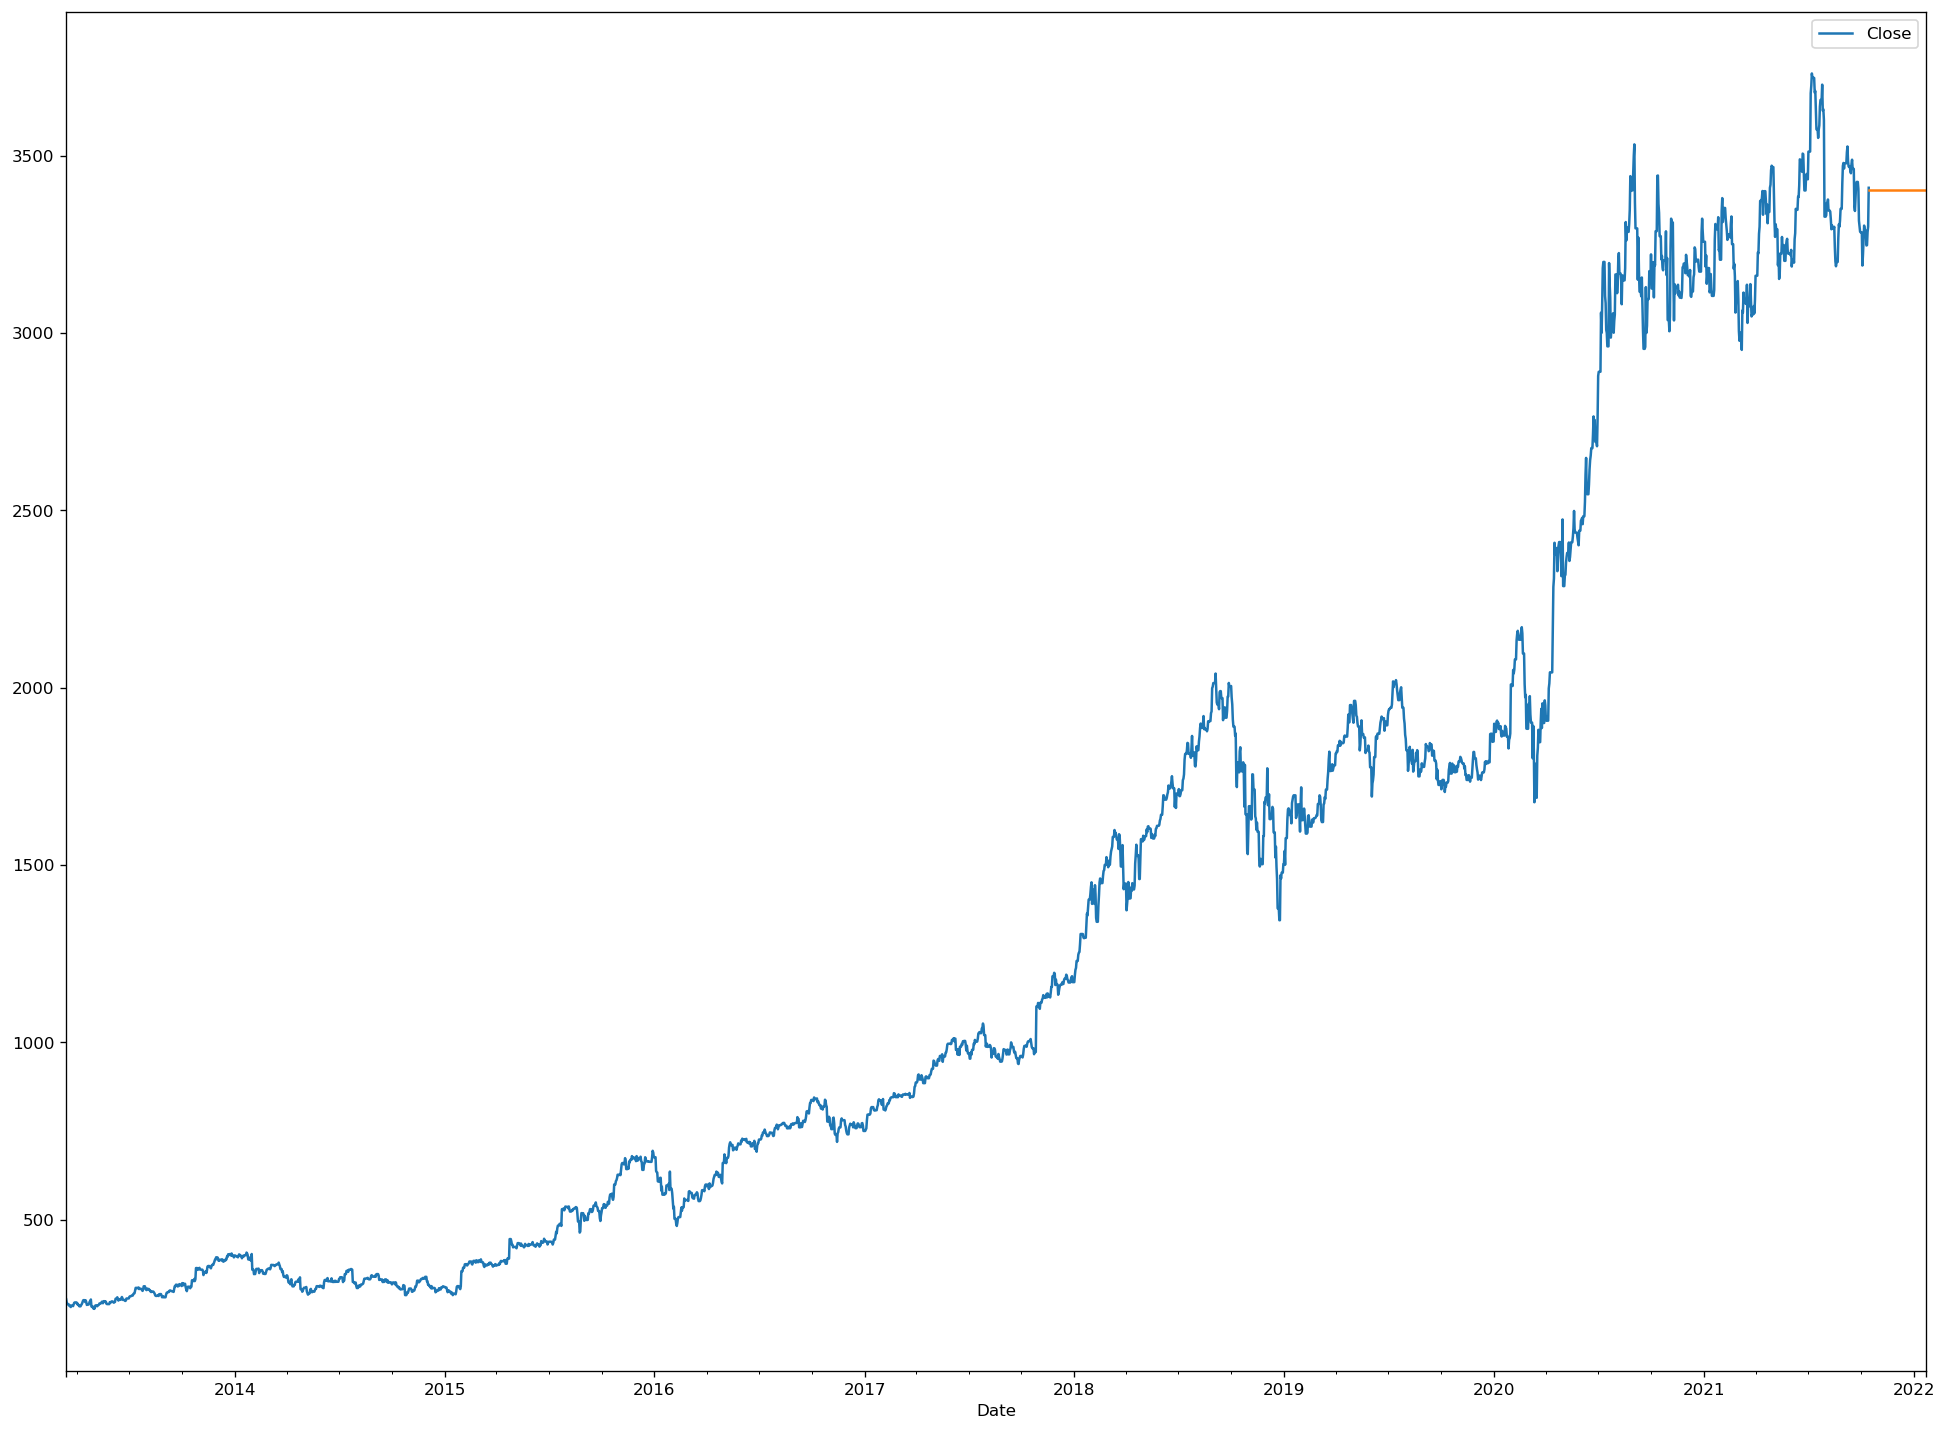

In [42]:
ax = amzn_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

## SARIMAX

In [65]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=16.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9975.399, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2338.126, Time=5.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6699.505, Time=6.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10078.509, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3301.968, Time=0.73 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1950.629, Time=24.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=54.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9966.949, Time=9.55 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1942.832, Time=29.63 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2328.054, Time=6.76 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=57.85 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=15.11 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept  

In [41]:
model2 = sm.tsa.statespace.SARIMAX(aapl_close, order=(3, 0, 2), seasonal_order=(2, 1, 0, 12))
model_2 = model2.fit()

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
pred2 = model_2.predict(start=pd.to_datetime('2018-09-07'), dynamic=False)
plt.show()

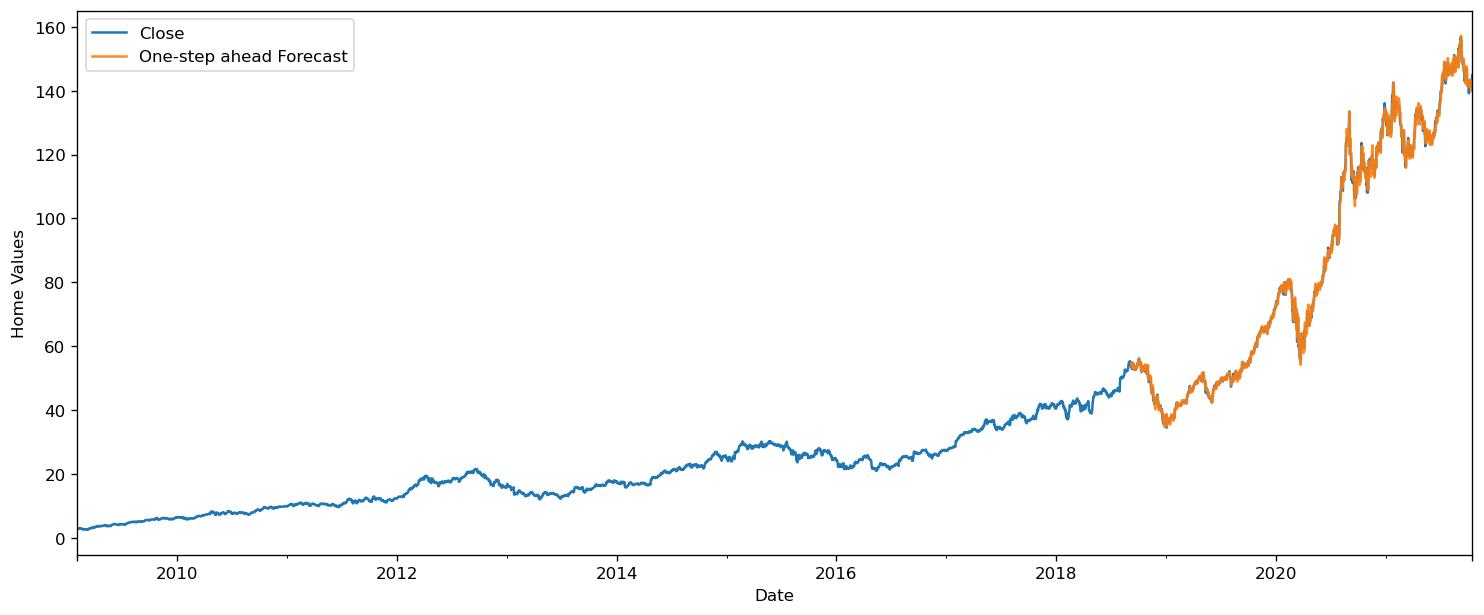

In [43]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aapl_close.plot(label='observed')

# Plot predicted values
pred2.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

In [44]:
value_forecasted = pred2
value_truth = aapl_close['Close']['2018-09-07':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 1.78


In [45]:
pred_uc = model_2.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

<AxesSubplot:xlabel='Date'>

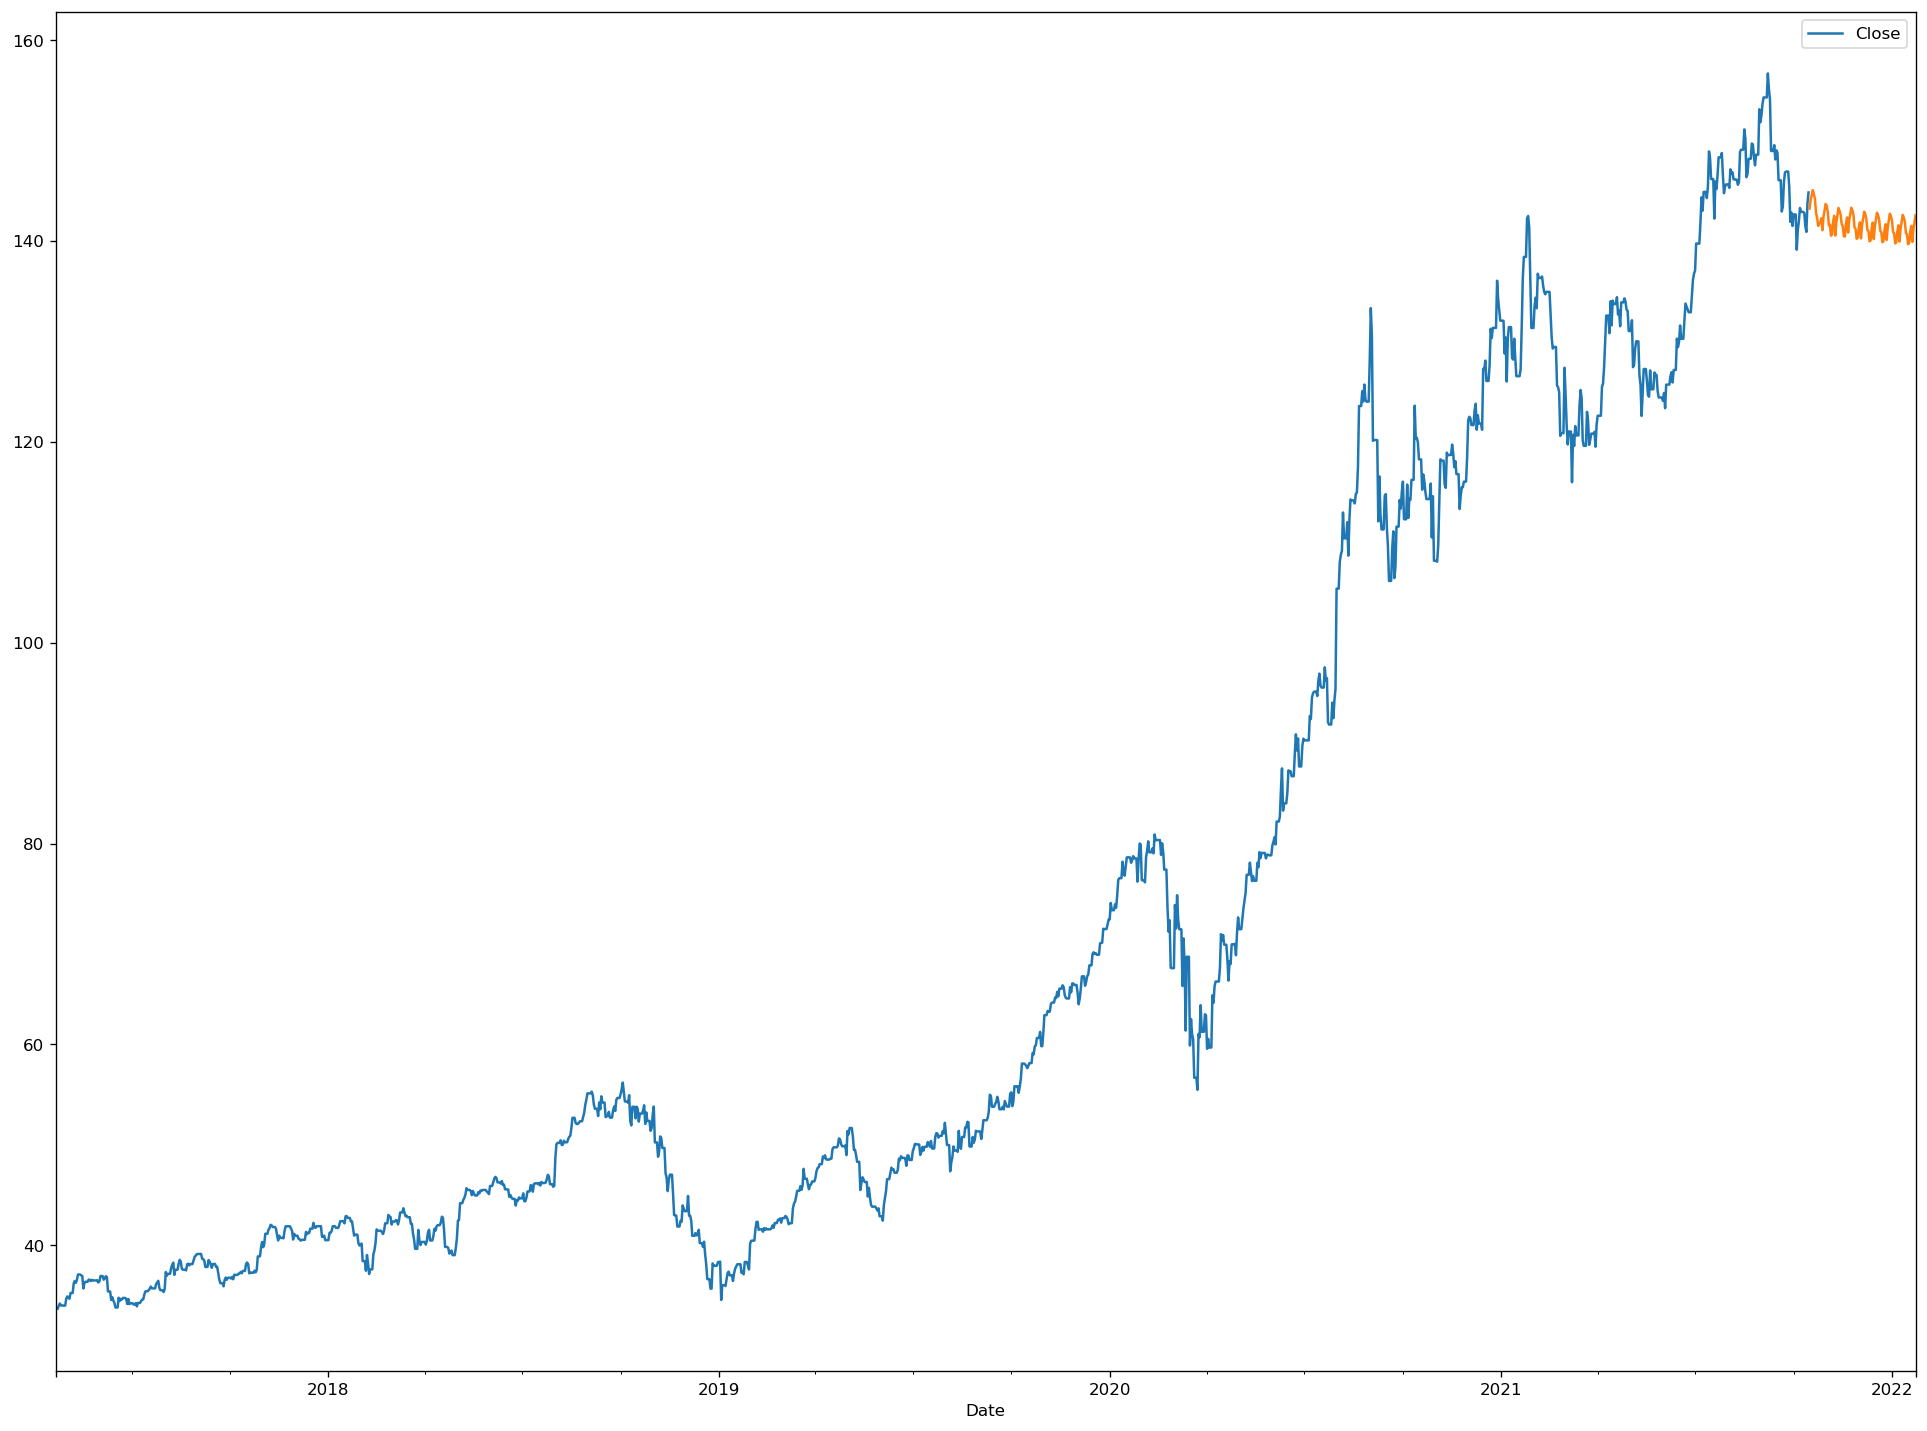

In [46]:
ax = aapl_close.iloc[3000:].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')